# Extract annotation information from UniProt

Note: Requires internet connection to download information from the [Universal Protein Resource (UniProt)](https://www.uniprot.org/).
*  [UniProt Knowledgebase (UniProtKB)](https://www.uniprot.org/help/uniprotkb)

## Citation
UniProt Consortium. UniProt: the Universal Protein Knowledgebase in 2023. Nucleic Acids Res. 2023 Jan 6;51(D1):D523-D531. doi: 10.1093/nar/gkac1052. PMID: 36408920; PMCID: PMC9825514.


## Setup
### Import packages

In [1]:
from warnings import warn
import pandas as pd
import matplotlib.pyplot as plt
import re

from rbc_gem_utils import (
    ROOT_PATH,
    DATABASE_PATH,
    ANNOTATION_PATH,
    INTERIM_PATH,
    GEM_NAME,
    read_rbc_model,
    get_annotation_df,
    compare_tables,
    split_string,
    build_string,
    visualize_comparison,
    check_database_version_online,
    check_version,
    show_versions,
)

from rbc_gem_utils.database.uniprot import (
    UNIPROT_VERSION_EXPECTED,
    UNIPROT_DB_TAG,
    UNIPROT_PATH,
    get_version_UniProt,
    query_UniProt,
    get_annotation_to_from_db_UniProt,
    get_label_miriam_mapping_UniProt,
    get_query_fields_UniProt,
    parse_isoforms_UniProt,
    parse_chains_UniProt,
    get_isoform_value_from_entry_UniProt,
)

from rbc_gem_utils.util import ensure_iterable

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Check UniProt version
If the version does not match the expected version, it is because database has been updated since the last time this code was utilized. 

### Expected UniProt version: 2024_02
* According to [UniProt](https://www.uniprot.org/help/downloads), updates to the database are made every eight weeks. 
* Last release utilized: [2024_01](https://www.uniprot.org/uniprotkb/statistics) published on **Wed Jan 24 2024**.

In [2]:
if not check_database_version_online(UNIPROT_DB_TAG):
    warn(
        "Online version of database has been updated since the last time notebook was used."
    )

version = get_version_UniProt()
if check_version(version, UNIPROT_VERSION_EXPECTED, verbose=True):
    database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}{UNIPROT_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
else:
    # Use different directory paths for unexpected behavior
    database_dirpath = f"{ROOT_PATH}{INTERIM_PATH}{UNIPROT_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{INTERIM_PATH}"
annotation_to_from_db = get_annotation_to_from_db_UniProt(miriam_only=True)

Current and expected versions match.


## Load RBC-GEM model

In [3]:
model = read_rbc_model(filetype="xml")
model

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-28


Name,RBC_GEM
Memory address,150106790
Number of metabolites,2057
Number of reactions,3030
Number of genes,779
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Download data from UniProt

### Get IDs for query
#### Using an existing annotation

In [4]:
annotation_type = "genes"
annotation_cols = ["uniprot"]
mapping_key = "uniprot"

df_model_mappings = (
    get_annotation_df(model.genes, annotation_cols)
    .rename({"id": annotation_type}, axis=1)
    .dropna(subset=[mapping_key])
)
for col in df_model_mappings.columns:
    df_model_mappings[col] = df_model_mappings[col].apply(lambda x: split_string(x))
    df_model_mappings = df_model_mappings.explode(col).drop_duplicates().dropna()
df_model_mappings = df_model_mappings.sort_values(annotation_type)

print(df_model_mappings.nunique(dropna=True))
df_model_mappings = df_model_mappings.reset_index(drop=True)
df_model_mappings

genes      779
uniprot    779
dtype: int64


,genes,uniprot
0,A4GALT,Q9NPC4
1,AARS1,P49588
2,AASDHPPT,Q9NRN7
3,ABCA1,O95477
4,ABCA7,Q8IZY2
...,...,...
774,YES1,P07947
775,ZDHHC2,Q9UIJ5
776,ZDHHC20,Q5W0Z9
777,ZDHHC3,Q9NYG2


In [5]:
from_db = annotation_to_from_db[mapping_key]
query_ids = df_model_mappings[mapping_key].dropna().unique()
assert len(set(query_ids)) == len(query_ids), "Duplicate IDs in list to query"
model_search_mapping = df_model_mappings.set_index(annotation_type)[
    mapping_key
].to_dict()
print(f"Number of model genes associated with query: {len(model_search_mapping)}")
print(f"Number of unique IDs to query: {len(query_ids)}")
df_model_mappings[[annotation_type, mapping_key]].drop_duplicates()

Number of model genes associated with query: 779
Number of unique IDs to query: 779


,genes,uniprot
0,A4GALT,Q9NPC4
1,AARS1,P49588
2,AASDHPPT,Q9NRN7
3,ABCA1,O95477
4,ABCA7,Q8IZY2
...,...,...
774,YES1,P07947
775,ZDHHC2,Q9UIJ5
776,ZDHHC20,Q5W0Z9
777,ZDHHC3,Q9NYG2


## Set notebook options

In [6]:
compare_figsize = (5, 20)
compare = True
display_nunique = True
overwrite = True
db_tag = UNIPROT_DB_TAG
all_query_results = {}

## Run queries
### Set universal query parameters

In [7]:
miriam_query_fields = get_query_fields_UniProt(miriam_only=True)
query_fields = miriam_query_fields + [
    # Add additional non-miriam fields if desired
    # Complex composition
    "cc_subunit",
    # Specific isoforms to include/avoid
    "cc_tissue_specificity",
    # Chromosome
    "xref_proteomes",
]

In [8]:
# Extract all relevant information for now and save
query_parameters = {
    "query": " && ".join(
        [
            "(reviewed:true)",
            "(organism_id:9606)",  # Homo sapiens (Human)
        ]
    ),
    "format": "tsv",
    "size": 500,
    "compressed": True,
    "fields": ",".join(query_fields),
}

### Initial query

In [9]:
query_key = "initial"
df_results, uniparc, failed_ids, obselete_counts = query_UniProt(
    list(query_ids),
    query_parameters=query_parameters,
    to_db="UniProtKB",
    from_db=from_db,
    return_failed=True,
)
if failed_ids:
    print(failed_ids)
all_query_results[query_key] = df_results
df_results

Fetched: 500 / 779
Fetched: 779 / 779


,From,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),EC number,Rhea ID,UniParc,Gene Ontology IDs,Chain,...,PANTHER,Pfam,PIRSF,PRINTS,PROSITE,SMART,SUPFAM,Subunit structure,Tissue specificity,Proteomes
0,A0AVT1,A0AVT1,UBA6,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,6.2.1.45,,UPI000004A4F7,GO:0004792; GO:0004839; GO:0005524; GO:0005737...,"CHAIN 1..1052; /note=""Ubiquitin-like modifier-...",...,PTHR10953;PTHR10953:SF186;,PF16191;PF16190;PF09358;PF00899;PF10585;,,PR01849;,,SM00985;,SSF69572;,SUBUNIT: Forms a thioester with UBD in cells s...,TISSUE SPECIFICITY: Widely expressed. Isoform ...,UP000005640: Chromosome 4
1,A4D126,A4D126,CRPPA,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.7.7.40,RHEA:12456 RHEA:53872 RHEA:53612,UPI00015CFC06,GO:0005829; GO:0007411; GO:0008299; GO:0035269...,"CHAIN 1..451; /note=""D-ribitol-5-phosphate cyt...",...,PTHR43015;PTHR43015:SF1;,PF01128;PF18706;,,,PS01295;,,SSF53448;,SUBUNIT: Homodimer. {ECO:0000269|PubMed:266871...,"TISSUE SPECIFICITY: Ubiquitously expressed, wi...",UP000005640: Chromosome 7
2,A6NDG6,A6NDG6,PGP,9606,ALTERNATIVE PRODUCTS:,3.1.3.21; 3.1.3.48,RHEA:10684 RHEA:46084 RHEA:66372,UPI00000473F8,GO:0000121; GO:0000287; GO:0004725; GO:0005737...,"CHAIN 1..321; /note=""Glycerol-3-phosphate phos...",...,PTHR19288;PTHR19288:SF93;,PF13344;PF13242;,PIRSF000915;,,,,SSF56784;,SUBUNIT: Homodimer. {ECO:0000250|UniProtKB:Q8C...,TISSUE SPECIFICITY: Detected in all tissues in...,UP000005640: Chromosome 16
3,A6NFX1,A6NFX1,MFSD2B,9606,ALTERNATIVE PRODUCTS:,,RHEA:38667 RHEA:38671 RHEA:70207,UPI000047F9C2,GO:0003376; GO:0005886; GO:0006869; GO:0008643...,"CHAIN 1..504; /note=""Sphingosine-1-phosphate t...",...,PTHR11328;PTHR11328:SF30;,PF13347;,,,,,SSF103473;,,,UP000005640: Chromosome 2
4,O00154,O00154,ACOT7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,3.1.2.2,RHEA:16645 RHEA:30143 RHEA:30135 RHEA:40139 RH...,UPI000012674F,GO:0000062; GO:0005654; GO:0005739; GO:0005829...,"CHAIN 1..380; /note=""Cytosolic acyl coenzyme A...",...,PTHR11049;PTHR11049:SF27;,PF03061;,,,PS51770;,,SSF54637;,SUBUNIT: Homohexamer. {ECO:0000250|UniProtKB:Q...,TISSUE SPECIFICITY: Isoform 4 is expressed exc...,UP000005640: Chromosome 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,Q9Y666,Q9Y666,SLC12A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,,RHEA:72427,UPI0000141815,GO:0005886; GO:0006811; GO:0006884; GO:0007268...,"CHAIN 1..1083; /note=""Solute carrier family 12...",...,PTHR11827:SF47;PTHR11827;,PF00324;PF03522;,,PR01081;,,,,SUBUNIT: Homomultimer and heteromultimer with ...,"TISSUE SPECIFICITY: Detected in muscle, brain,...",UP000005640: Chromosome 5
775,Q9Y694,Q9Y694,SLC22A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,,RHEA:72043 RHEA:76207 RHEA:76211 RHEA:76215 RH...,UPI000006F307,GO:0005829; GO:0005886; GO:0006805; GO:0006811...,"CHAIN 1..548; /note=""Solute carrier family 22 ...",...,PTHR24064;PTHR24064:SF33;,PF07690;,,,PS50850;,,SSF103473;,,TISSUE SPECIFICITY: Mainly expressed in liver ...,UP000005640: Chromosome 6
776,Q9Y696,Q9Y696,CLIC4,9606,ALTERNATIVE PRODUCTS:,,,UPI0000127AC9,GO:0001525; GO:0001886; GO:0005254; GO:0005737...,"CHAIN 2..253; /note=""Chloride intracellular ch...",...,PTHR45476:SF5;PTHR45476;,PF13409;,,PR01263;,PS50405;,,SSF47616;SSF52833;,SUBUNIT: Component of a multimeric complex con...,TISSUE SPECIFICITY: Detected in epithelial cel...,UP000005640: Chromosome 1
777,Q9Y6M4,Q9Y6M4,CSNK1G3,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.7.11.1,RHEA:17989 RHEA:46608,UPI000035B1BD,GO:0004672; GO:0004674; GO:0005524; GO:0005634...,"CHAIN 1..447; /note=""Casein kinase I isoform g...",...,PTHR11909:SF151;PTHR11909;,PF12605;PF00069;,,,PS00107;PS50011;PS00108;,SM00220;,SSF56112;,SUBUNIT: Monomer. {ECO:0000250}.,,UP000005640: Chromosome 5


### Address failed IDs


In [10]:
# retry_ids = {}
# query_key = "retry_1"
# df_results, failed_ids = query_UniProt(
#     list(sorted(retry_ids.values())),
#     from_db="UniProtKB",
#     query_parameters=query_parameters
# )
# if failed_ids:
#     print(failed_ids)
# all_query_results[query_key] = df_results
# model_search_mapping.update({
#     k: retry_ids[v] for k, v in model_search_mapping.items()
#     if v in retry_ids and v not in failed_ids
# })
# df_results

## Concat, cleanup, and save query results

In [11]:
print(f"Number of unique queries: {len(all_query_results)}")
df_query_results = pd.concat(tuple(all_query_results.values()))
df_query_results = df_query_results.set_index("From").drop_duplicates()
df_query_results = df_query_results.replace("", pd.NA)
df_query_results

Number of unique queries: 1


,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),EC number,Rhea ID,UniParc,Gene Ontology IDs,Chain,PubMed ID,...,PANTHER,Pfam,PIRSF,PRINTS,PROSITE,SMART,SUPFAM,Subunit structure,Tissue specificity,Proteomes
From,,,,,,,,,,,,,,,,,,,,,
A0AVT1,A0AVT1,UBA6,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,6.2.1.45,<NA>,UPI000004A4F7,GO:0004792; GO:0004839; GO:0005524; GO:0005737...,"CHAIN 1..1052; /note=""Ubiquitin-like modifier-...",15202508; 17597759; 14702039; 17974005; 158156...,...,PTHR10953;PTHR10953:SF186;,PF16191;PF16190;PF09358;PF00899;PF10585;,<NA>,PR01849;,<NA>,SM00985;,SSF69572;,SUBUNIT: Forms a thioester with UBD in cells s...,TISSUE SPECIFICITY: Widely expressed. Isoform ...,UP000005640: Chromosome 4
A4D126,A4D126,CRPPA,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.7.7.40,RHEA:12456 RHEA:53872 RHEA:53612,UPI00015CFC06,GO:0005829; GO:0007411; GO:0008299; GO:0035269...,"CHAIN 1..451; /note=""D-ribitol-5-phosphate cyt...",12853948; 12690205; 22522420; 26923585; 271307...,...,PTHR43015;PTHR43015:SF1;,PF01128;PF18706;,<NA>,<NA>,PS01295;,<NA>,SSF53448;,SUBUNIT: Homodimer. {ECO:0000269|PubMed:266871...,"TISSUE SPECIFICITY: Ubiquitously expressed, wi...",UP000005640: Chromosome 7
A6NDG6,A6NDG6,PGP,9606,ALTERNATIVE PRODUCTS:,3.1.3.21; 3.1.3.48,RHEA:10684 RHEA:46084 RHEA:66372,UPI00000473F8,GO:0000121; GO:0000287; GO:0004725; GO:0005737...,"CHAIN 1..321; /note=""Glycerol-3-phosphate phos...",15616553; 215071; 21269460; 26755581,...,PTHR19288;PTHR19288:SF93;,PF13344;PF13242;,PIRSF000915;,<NA>,<NA>,<NA>,SSF56784;,SUBUNIT: Homodimer. {ECO:0000250|UniProtKB:Q8C...,TISSUE SPECIFICITY: Detected in all tissues in...,UP000005640: Chromosome 16
A6NFX1,A6NFX1,MFSD2B,9606,ALTERNATIVE PRODUCTS:,<NA>,RHEA:38667 RHEA:38671 RHEA:70207,UPI000047F9C2,GO:0003376; GO:0005886; GO:0006869; GO:0008643...,"CHAIN 1..504; /note=""Sphingosine-1-phosphate t...",15815621; 18694395; 29045386; 29563527,...,PTHR11328;PTHR11328:SF30;,PF13347;,<NA>,<NA>,<NA>,<NA>,SSF103473;,<NA>,<NA>,UP000005640: Chromosome 2
O00154,O00154,ACOT7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,3.1.2.2,RHEA:16645 RHEA:30143 RHEA:30135 RHEA:40139 RH...,UPI000012674F,GO:0000062; GO:0005654; GO:0005739; GO:0005829...,"CHAIN 1..380; /note=""Cytosolic acyl coenzyme A...",10578051; 12435388; 14702039; 16710414; 154893...,...,PTHR11049;PTHR11049:SF27;,PF03061;,<NA>,<NA>,PS51770;,<NA>,SSF54637;,SUBUNIT: Homohexamer. {ECO:0000250|UniProtKB:Q...,TISSUE SPECIFICITY: Isoform 4 is expressed exc...,UP000005640: Chromosome 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y666,Q9Y666,SLC12A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,<NA>,RHEA:72427,UPI0000141815,GO:0005886; GO:0006811; GO:0006884; GO:0007268...,"CHAIN 1..1083; /note=""Solute carrier family 12...",10347194; 15372022; 15489334; 11214971; 179740...,...,PTHR11827:SF47;PTHR11827;,PF00324;PF03522;,<NA>,PR01081;,<NA>,<NA>,<NA>,SUBUNIT: Homomultimer and heteromultimer with ...,"TISSUE SPECIFICITY: Detected in muscle, brain,...",UP000005640: Chromosome 5
Q9Y694,Q9Y694,SLC22A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,<NA>,RHEA:72043 RHEA:76207 RHEA:76211 RHEA:76215 RH...,UPI000006F307,GO:0005829; GO:0005886; GO:0006805; GO:0006811...,"CHAIN 1..548; /note=""Solute carrier family 22 ...",14702039; 14574404; 15489334; 11327718; 120235...,...,PTHR24064;PTHR24064:SF33;,PF07690;,<NA>,<NA>,PS50850;,<NA>,SSF103473;,<NA>,TISSUE SPECIFICITY: Mainly expressed in liver ...,UP000005640: Chromosome 6
Q9Y696,Q9Y696,CLIC4,9606,ALTERNATIVE PRODUCTS:,<NA>,<NA>,UPI0000127AC9,GO:0001525; GO:0001886; GO:0005254; GO:0005737...,"CHAIN 2..253; /note=""Chloride intracellular ch...",10070163; 10191309; 11230166; 15489334; 107931...,...,PTHR45476:SF5;PTHR45476;,PF13409;,<NA>,PR01263;,PS50405;,<NA>,SSF47616;SSF52833;,SUBUNIT: Component of a multimeric complex con...,TISSUE SPECIFICITY: Detected in epithelial cel...,UP000005640: Chromosome 1


### Save extracted data to database

,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),EC number,Rhea ID,UniParc,Gene Ontology IDs,Chain,PubMed ID,...,PANTHER,Pfam,PIRSF,PRINTS,PROSITE,SMART,SUPFAM,Subunit structure,Tissue specificity,Proteomes
0,A0AVT1,UBA6,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,6.2.1.45,<NA>,UPI000004A4F7,GO:0004792; GO:0004839; GO:0005524; GO:0005737...,"CHAIN 1..1052; /note=""Ubiquitin-like modifier-...",15202508; 17597759; 14702039; 17974005; 158156...,...,PTHR10953;PTHR10953:SF186;,PF16191;PF16190;PF09358;PF00899;PF10585;,<NA>,PR01849;,<NA>,SM00985;,SSF69572;,SUBUNIT: Forms a thioester with UBD in cells s...,TISSUE SPECIFICITY: Widely expressed. Isoform ...,UP000005640: Chromosome 4
1,A4D126,CRPPA,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.7.7.40,RHEA:12456 RHEA:53872 RHEA:53612,UPI00015CFC06,GO:0005829; GO:0007411; GO:0008299; GO:0035269...,"CHAIN 1..451; /note=""D-ribitol-5-phosphate cyt...",12853948; 12690205; 22522420; 26923585; 271307...,...,PTHR43015;PTHR43015:SF1;,PF01128;PF18706;,<NA>,<NA>,PS01295;,<NA>,SSF53448;,SUBUNIT: Homodimer. {ECO:0000269|PubMed:266871...,"TISSUE SPECIFICITY: Ubiquitously expressed, wi...",UP000005640: Chromosome 7
2,A6NDG6,PGP,9606,ALTERNATIVE PRODUCTS:,3.1.3.21; 3.1.3.48,RHEA:10684 RHEA:46084 RHEA:66372,UPI00000473F8,GO:0000121; GO:0000287; GO:0004725; GO:0005737...,"CHAIN 1..321; /note=""Glycerol-3-phosphate phos...",15616553; 215071; 21269460; 26755581,...,PTHR19288;PTHR19288:SF93;,PF13344;PF13242;,PIRSF000915;,<NA>,<NA>,<NA>,SSF56784;,SUBUNIT: Homodimer. {ECO:0000250|UniProtKB:Q8C...,TISSUE SPECIFICITY: Detected in all tissues in...,UP000005640: Chromosome 16
3,A6NFX1,MFSD2B,9606,ALTERNATIVE PRODUCTS:,<NA>,RHEA:38667 RHEA:38671 RHEA:70207,UPI000047F9C2,GO:0003376; GO:0005886; GO:0006869; GO:0008643...,"CHAIN 1..504; /note=""Sphingosine-1-phosphate t...",15815621; 18694395; 29045386; 29563527,...,PTHR11328;PTHR11328:SF30;,PF13347;,<NA>,<NA>,<NA>,<NA>,SSF103473;,<NA>,<NA>,UP000005640: Chromosome 2
4,O00154,ACOT7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,3.1.2.2,RHEA:16645 RHEA:30143 RHEA:30135 RHEA:40139 RH...,UPI000012674F,GO:0000062; GO:0005654; GO:0005739; GO:0005829...,"CHAIN 1..380; /note=""Cytosolic acyl coenzyme A...",10578051; 12435388; 14702039; 16710414; 154893...,...,PTHR11049;PTHR11049:SF27;,PF03061;,<NA>,<NA>,PS51770;,<NA>,SSF54637;,SUBUNIT: Homohexamer. {ECO:0000250|UniProtKB:Q...,TISSUE SPECIFICITY: Isoform 4 is expressed exc...,UP000005640: Chromosome 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,Q9Y666,SLC12A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,<NA>,RHEA:72427,UPI0000141815,GO:0005886; GO:0006811; GO:0006884; GO:0007268...,"CHAIN 1..1083; /note=""Solute carrier family 12...",10347194; 15372022; 15489334; 11214971; 179740...,...,PTHR11827:SF47;PTHR11827;,PF00324;PF03522;,<NA>,PR01081;,<NA>,<NA>,<NA>,SUBUNIT: Homomultimer and heteromultimer with ...,"TISSUE SPECIFICITY: Detected in muscle, brain,...",UP000005640: Chromosome 5
775,Q9Y694,SLC22A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,<NA>,RHEA:72043 RHEA:76207 RHEA:76211 RHEA:76215 RH...,UPI000006F307,GO:0005829; GO:0005886; GO:0006805; GO:0006811...,"CHAIN 1..548; /note=""Solute carrier family 22 ...",14702039; 14574404; 15489334; 11327718; 120235...,...,PTHR24064;PTHR24064:SF33;,PF07690;,<NA>,<NA>,PS50850;,<NA>,SSF103473;,<NA>,TISSUE SPECIFICITY: Mainly expressed in liver ...,UP000005640: Chromosome 6
776,Q9Y696,CLIC4,9606,ALTERNATIVE PRODUCTS:,<NA>,<NA>,UPI0000127AC9,GO:0001525; GO:0001886; GO:0005254; GO:0005737...,"CHAIN 2..253; /note=""Chloride intracellular ch...",10070163; 10191309; 11230166; 15489334; 107931...,...,PTHR45476:SF5;PTHR45476;,PF13409;,<NA>,PR01263;,PS50405;,<NA>,SSF47616;SSF52833;,SUBUNIT: Component of a multimeric complex con...,TISSUE SPECIFICITY: Detected in epithelial cel...,UP000005640: Chromosome 1
777,Q9Y6M4,CSNK1G3,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,

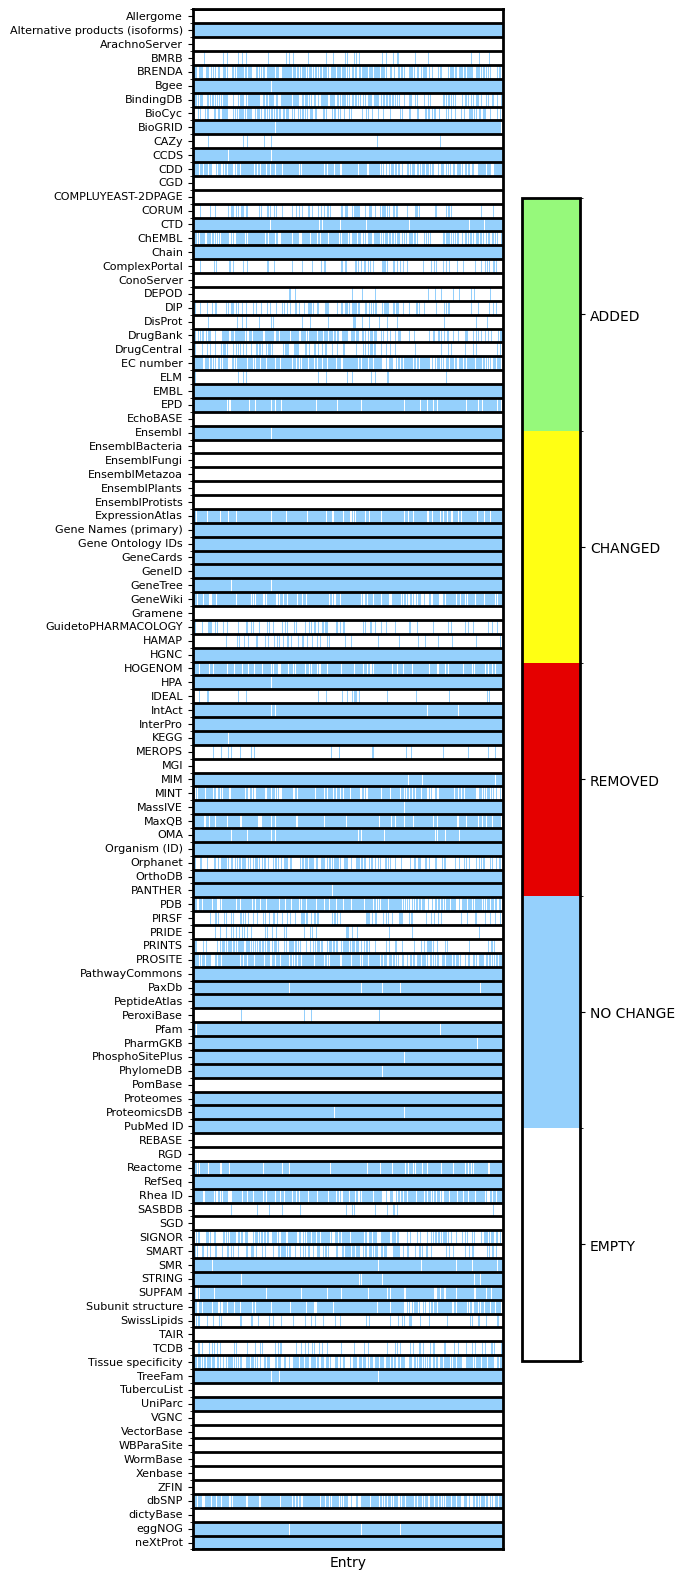

In [12]:
# Save query results to external database
df_database = df_query_results.reset_index(drop=True).drop_duplicates()
if compare:
    compare_on_index = ["Entry"]
    try:
        df_previous = pd.read_csv(
            f"{database_dirpath}/{db_tag}_{GEM_NAME}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index), df_database.set_index(compare_on_index)
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)


if overwrite:
    df_database.to_csv(
        f"{database_dirpath}/{db_tag}_{GEM_NAME}.tsv", sep="\t", index=False
    )
else:
    df_database.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{db_tag}_{GEM_NAME}.tsv", sep="\t", index=False
    )
df_database

## Format UniProt information for annotation files
### Genes
#### Map to chosen MIRIAMs
As formatting may be needed for some MIRIAMS, keep it simple for now until formatting methods are developed. 

In [13]:
annotation_type = "genes"

# Keeping it simple for now, group items regardless of isoforms for the time being
uniprot_miriam_mapping = get_label_miriam_mapping_UniProt(
    get_query_fields_UniProt(miriam_only=True)
)
uniprot_miriam_mapping["Proteomes"] = "chromosome"

merge_key = {
    v: k for k, v in uniprot_miriam_mapping.items() if v in df_model_mappings.columns
}[mapping_key]
df_annotations = df_model_mappings.set_index(mapping_key).merge(
    df_database, left_index=True, right_on=merge_key, how="left"
)
df_annotations = (
    df_annotations.set_index(annotation_type)
    .loc[:, list(uniprot_miriam_mapping)]
    .rename(uniprot_miriam_mapping, axis=1)
)
uniprot_columns = ["uniprot", "uniprot.isoform", "uniprot.chain"]
# For the most part, these columns do not require any reformatting or are easy to work with.
annotation_columns = [
    "hgnc.symbol",
    "ec-code",
    "taxonomy",
    "uniparc",
    # Reactions
    "rhea",
    # Gene Ontology (GO)
    "go",
    # Sequence
    "ccds",
    "ena.embl",
    "refseq",
    # 3D Structure
    "bmrb",
    "pdb",
    "sasbdb",
    "smr",
    # Protein-protein interaction
    "biogrid",
    "complexportal",
    "dip",
    "intact",
    # Chemistry databases
    "chembl.target",
    "drugbank",
    "iuphar.receptor",
    # Protein family/group databases
    "cazy",
    "ideal",
    "merops",
    "peroxibase",
    "tcdb",
    # Genetic variation/Polymorphism and mutation databases
    "dbsnp",
    # Proteomic databases
    "proteomicsdb.protein",
    # Genome annotation databases
    "ensembl",
    "ncbigene",
    ## Organism-specific
    "kegg.genes",
    "genecards",
    "hgnc",
    "hpa",
    "mim",
    "nextprot",
    "orphanet",
    "pharmgkb.gene",
    # Phylogenomic databases
    "eggnog",
    "genetree",
    "hogenom",
    "oma.grp",
    "orthodb",
    "treefam",
    # Enzyme and pathway databases
    "biocyc",
    "brenda",
    "reactome",
    # Miscellaneous databases
    "genewiki",
    # Gene expression databases
    "bgee.gene",
    ## Family and domain databases
    "cdd",
    "disprot",
    "hamap",
    "interpro",
    "panther.family",
    "pfam",
    "pirsf",
    "prints",
    "prosite",
    "smart",
    "supfam",
    "chromosome",
]
df_annotations["chromosome"] = df_annotations["chromosome"].apply(
    lambda x: x.split(" ")[-1]
)
df_annotations = df_annotations.loc[:, uniprot_columns + annotation_columns]
print(f"Fields searched: {df_annotations.shape[1]}")
all_na = df_annotations.T[df_annotations.isna().all(axis=0)].index
annotation_columns = [x for x in annotation_columns if x not in all_na]
df_annotations = df_annotations.dropna(how="all", axis=1)
print(f"Empty dropped: {len(all_na)}")
print(f"Remaining: {df_annotations.shape[1]}")
df_annotations = df_annotations.reset_index(drop=False).replace(pd.NA, "")
df_annotations

Fields searched: 63
Empty dropped: 0
Remaining: 63


,genes,uniprot,uniprot.isoform,uniprot.chain,hgnc.symbol,ec-code,taxonomy,uniparc,rhea,go,...,hamap,interpro,panther.family,pfam,pirsf,prints,prosite,smart,supfam,chromosome
0,A4GALT,Q9NPC4,ALTERNATIVE PRODUCTS:,"CHAIN 1..353; /note=""Lactosylceramide 4-alpha-...",A4GALT,2.4.1.228,9606,UPI000003FF92,RHEA:11924 RHEA:60044,GO:0000139; GO:0001576; GO:0006493; GO:0006688...,...,,IPR007652;IPR007577;IPR029044;,PTHR12042:SF17;PTHR12042;,PF04572;PF04488;,,,,,SSF53448;,22
1,AARS1,P49588,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..968; /note=""Alanine--tRNA ligase, cyt...",AARS1,6.1.1.7,9606,UPI0000169F0B,RHEA:12540,GO:0000049; GO:0002161; GO:0002196; GO:0004813...,...,MF_00036_B;,IPR045864;IPR002318;IPR018162;IPR018165;IPR018...,PTHR11777:SF36;PTHR11777;,PF02272;PF01411;PF07973;,,PR00980;,PS50860;,SM00863;,SSF55681;SSF101353;SSF55186;SSF50447;,16
2,AASDHPPT,Q9NRN7,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..309; /note=""L-aminoadipate-semialdehy...",AASDHPPT,2.7.8.7,9606,UPI0000034CAD,RHEA:12068 RHEA:46564,GO:0000287; GO:0005829; GO:0008897; GO:0009258...,...,,IPR008278;IPR037143;,PTHR12215:SF10;PTHR12215;,PF01648;,,,,,SSF56214;,11
3,ABCA1,O95477,ALTERNATIVE PRODUCTS:,"CHAIN 1..2261; /note=""Phospholipid-transportin...",ABCA1,7.6.2.1,9606,UPI000013E441,RHEA:38583 RHEA:38567 RHEA:38903 RHEA:39051,GO:0002790; GO:0005102; GO:0005524; GO:0005548...,...,,IPR003593;IPR013525;IPR003439;IPR017871;IPR026...,PTHR19229;PTHR19229:SF34;,PF12698;PF00005;,,,PS00211;PS50893;,SM00382;,SSF52540;,9
4,ABCA7,Q8IZY2,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..2146; /note=""Phospholipid-transportin...",ABCA7,7.6.2.1,9606,UPI000013D3A4,RHEA:38583 RHEA:38567,GO:0000139; GO:0001891; GO:0005524; GO:0005548...,...,,IPR003593;IPR013525;IPR003439;IPR017871;IPR026...,PTHR19229;PTHR19229:SF49;,PF12698;PF00005;,,,PS00211;PS50893;,SM00382;,SSF52540;,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,YES1,P07947,ALTERNATIVE PRODUCTS:,"CHAIN 2..543; /note=""Tyrosine-protein kinase Y...",YES1,2.7.10.2,9606,UPI0000062316,RHEA:10596,GO:0001784; GO:0002862; GO:0004713; GO:0004715...,...,,IPR011009;IPR000719;IPR017441;IPR001245;IPR000...,PTHR24418;PTHR24418:SF90;,PF07714;PF00017;PF00018;,,PR00401;PR00452;PR00109;,PS00107;PS50011;PS00109;PS50001;PS50002;,SM00252;SM00326;SM00219;,SSF56112;SSF55550;SSF50044;,18
775,ZDHHC2,Q9UIJ5,ALTERNATIVE PRODUCTS:,"CHAIN 1..367; /note=""Palmitoyltransferase ZDHH...",ZDHHC2,2.3.1.-; 2.3.1.225,9606,UPI000004A02F,RHEA:36683 RHEA:59736 RHEA:59740,GO:0000139; GO:0005783; GO:0005789; GO:0005794...,...,,IPR001594;,PTHR12246;PTHR12246:SF13;,PF01529;,,,PS50216;,,,8
776,ZDHHC20,Q5W0Z9,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..365; /note=""Palmitoyltransferase ZDHH...",ZDHHC20,2.3.1.-; 2.3.1.225,9606,UPI000045881B,RHEA:36683 RHEA:59736 RHEA:59740,GO:0000139; GO:0005783; GO:0005789; GO:0005794...,...,,IPR001594;,PTHR12246;PTHR12246:SF13;,PF01529;,,,PS50216;,,,13
777,ZDHHC3,Q9NYG2,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..299; /note=""Palmitoyltransferase ZDHH...",ZDHHC3,2.3.1.-; 2.3.1.225,9606,UPI000002B749,RHEA:36683 RHEA:59736 RHEA:59740,GO:0000139; GO:0005783; GO:0005794; GO:0006612...,...,,IPR001594;,PTHR12246;PTHR12246:SF19;,PF01529;,,,PS50216;,,,3


In [14]:
df_isoforms = parse_isoforms_UniProt(
    df_annotations.loc[:, ["uniprot", "uniprot.isoform"]].copy(), add_canonical=True
)

df_canonical = df_isoforms[df_isoforms["uniprot.canonical"].apply(bool)].set_index(
    "uniprot"
)
df_canonical = df_canonical.apply(
    lambda x: x["uniprot.isoform"] if x["uniprot.isoform"] else x.name, axis=1
)
df_isoforms = df_isoforms.groupby("uniprot")[["uniprot.isoform"]].agg(
    lambda x: build_string(x)
)

df_chains = parse_chains_UniProt(
    df_annotations.loc[:, ["uniprot", "uniprot.chain"]].copy()
)
df_isoforms_chains = df_chains.merge(df_isoforms, right_index=True, left_on="uniprot")
df_isoforms_chains

,uniprot,uniprot.chain,uniprot.isoform
0,Q9NPC4,PRO_0000080578,
1,P49588,PRO_0000075281,P49588-1;P49588-2
2,Q9NRN7,PRO_0000175736,Q9NRN7-1;Q9NRN7-2
3,O95477,PRO_0000093288,
4,Q8IZY2,PRO_0000250674,Q8IZY2-1;Q8IZY2-2
...,...,...,...
774,P07947,PRO_0000088181,
775,Q9UIJ5,PRO_0000212859,
776,Q5W0Z9,PRO_0000212906,Q5W0Z9-1;Q5W0Z9-2;Q5W0Z9-3;Q5W0Z9-4
777,Q9NYG2,PRO_0000422064,Q9NYG2-1;Q9NYG2-2


genes: 779
uniprot: 779
uniprot.isoform: 1490
uniprot.chain: 825
hgnc.symbol: 780
ec-code: 510
taxonomy: 1
uniparc: 779
rhea: 1376
go: 5735
ccds: 1348
ena.embl: 8027
refseq: 2342
bmrb: 88
pdb: 11271
sasbdb: 38
smr: 762
biogrid: 781
complexportal: 365
dip: 243
intact: 771
chembl.target: 504
drugbank: 2281
iuphar.receptor: 169
cazy: 18
ideal: 41
merops: 38
peroxibase: 11
tcdb: 143
dbsnp: 4682
proteomicsdb.protein: 1673
ensembl: 2293
ncbigene: 784
kegg.genes: 783
genecards: 780
hgnc: 780
hpa: 778
mim: 1291
nextprot: 779
orphanet: 521
pharmgkb.gene: 774
eggnog: 590
genetree: 713
hogenom: 565
oma.grp: 743
orthodb: 555
treefam: 594
biocyc: 285
brenda: 395
reactome: 1035
genewiki: 594
bgee.gene: 778
cdd: 620
disprot: 43
hamap: 89
interpro: 1899
panther.family: 1314
pfam: 722
pirsf: 148
prints: 193
prosite: 398
smart: 181
supfam: 317
chromosome: 25


,genes,uniprot,uniprot.isoform,uniprot.chain,hgnc.symbol,ec-code,taxonomy,uniparc,rhea,go,...,hamap,interpro,panther.family,pfam,pirsf,prints,prosite,smart,supfam,chromosome
0,A4GALT,Q9NPC4,<NA>,PRO_0000080578,A4GALT,2.4.1.228,9606,UPI000003FF92,11924;60044,0000139;0001576;0006493;0006688;0007009;000837...,...,<NA>,IPR007652;IPR007577;IPR029044,PTHR12042:SF17;PTHR12042,PF04572;PF04488,<NA>,<NA>,<NA>,<NA>,SSF53448,22
1,AARS1,P49588,P49588-1;P49588-2,PRO_0000075281,AARS1,6.1.1.7,9606,UPI0000169F0B,12540,0000049;0002161;0002196;0004813;0005524;000573...,...,MF_00036_B,IPR045864;IPR002318;IPR018162;IPR018165;IPR018...,PTHR11777:SF36;PTHR11777,PF02272;PF01411;PF07973,<NA>,PR00980,PS50860,SM00863,SSF55681;SSF101353;SSF55186;SSF50447,16
2,AASDHPPT,Q9NRN7,Q9NRN7-1;Q9NRN7-2,PRO_0000175736,AASDHPPT,2.7.8.7,9606,UPI0000034CAD,12068;46564,0000287;0005829;0008897;0009258;0015939;001987...,...,<NA>,IPR008278;IPR037143,PTHR12215:SF10;PTHR12215,PF01648,<NA>,<NA>,<NA>,<NA>,SSF56214,11
3,ABCA1,O95477,<NA>,PRO_0000093288,ABCA1,7.6.2.1,9606,UPI000013E441,38583;38567;38903;39051,0002790;0005102;0005524;0005548;0005768;000578...,...,<NA>,IPR003593;IPR013525;IPR003439;IPR017871;IPR026...,PTHR19229;PTHR19229:SF34,PF12698;PF00005,<NA>,<NA>,PS00211;PS50893,SM00382,SSF52540,9
4,ABCA7,Q8IZY2,Q8IZY2-1;Q8IZY2-2,PRO_0000250674,ABCA7,7.6.2.1,9606,UPI000013D3A4,38583;38567,0000139;0001891;0005524;0005548;0005783;000579...,...,<NA>,IPR003593;IPR013525;IPR003439;IPR017871;IPR026...,PTHR19229;PTHR19229:SF49,PF12698;PF00005,<NA>,<NA>,PS00211;PS50893,SM00382,SSF52540,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,YES1,P07947,<NA>,PRO_0000088181,YES1,2.7.10.2,9606,UPI0000062316,10596,0001784;0002862;0004713;0004715;0005102;000552...,...,<NA>,IPR011009;IPR000719;IPR017441;IPR001245;IPR000...,PTHR24418;PTHR24418:SF90,PF07714;PF00017;PF00018,<NA>,PR00401;PR00452;PR00109,PS00107;PS50011;PS00109;PS50001;PS50002,SM00252;SM00326;SM00219,SSF56112;SSF55550;SSF50044,18
775,ZDHHC2,Q9UIJ5,<NA>,PRO_0000212859,ZDHHC2,2.3.1.-;2.3.1.225,9606,UPI000004A02F,36683;59736;59740,0000139;0005783;0005789;0005794;0005886;000661...,...,<NA>,IPR001594,PTHR12246;PTHR12246:SF13,PF01529,<NA>,<NA>,PS50216,<NA>,<NA>,8
776,ZDHHC20,Q5W0Z9,Q5W0Z9-1;Q5W0Z9-2;Q5W0Z9-3;Q5W0Z9-4,PRO_0000212906,ZDHHC20,2.3.1.-;2.3.1.225,9606,UPI000045881B,36683;59736;59740,0000139;0005783;0005789;0005794;0005886;000661...,...,<NA>,IPR001594,PTHR12246;PTHR12246:SF13,PF01529,<NA>,<NA>,PS50216,<NA>,<NA>,13
777,ZDHHC3,Q9NYG2,Q9NYG2-1;Q9NYG2-2,PRO_0000422064,ZDHHC3,2.3.1.-;2.3.1.225,9606,UPI000002B749,36683;59736;59740,0000139;0005783;0005794;0006612;0008277;001602...,...,<NA>,IPR001594,PTHR12246;PTHR12246:SF19,PF01529,<NA>,<NA>,PS50216,<NA>,<NA>,3


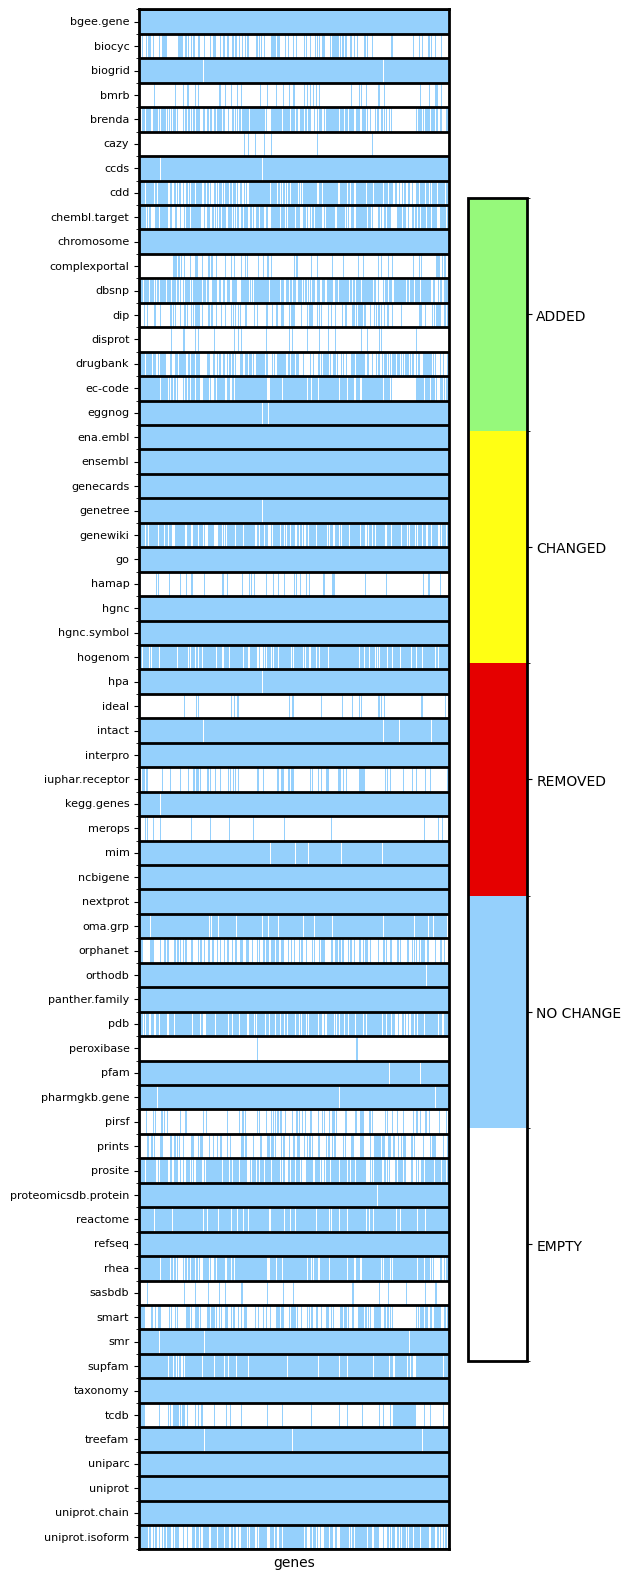

In [15]:
for col, series in df_isoforms_chains.items():
    df_annotations[col] = series

for idx, row in df_annotations.loc[:, annotation_columns].iterrows():
    uniprot_id, isoform_id = df_isoforms_chains.loc[idx, ["uniprot", "uniprot.isoform"]]
    if isoform_id and len(isoform_id.split(";")) != 1:
        isoform_id = None
    # No isoform ID set, just aggregate all without regards to isoform.
    row = row.apply(lambda x: get_isoform_value_from_entry_UniProt(x, isoform_id))
    # A duplicate reindexing error may here may mean duplicate columns in annotation column values
    df_annotations.loc[idx, annotation_columns] = row.values
# Clean up other annotations
keys = ["rhea", "go", "hgnc"]
for key in keys:
    if key in df_annotations.columns:
        df_annotations[key] = (
            df_annotations[key]
            .fillna("")
            .apply(
                lambda x: build_string(
                    [s.lstrip(f"{key.upper()}:") for s in split_string(x)]
                )
            )
        )


df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{db_tag}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")
if overwrite:
    df_annotations.to_csv(
        f"{annotation_dirpath}/{annotation_type}_{db_tag}.tsv", sep="\t", index=False
    )
else:
    df_annotations.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{db_tag}.tsv",
        sep="\t",
        index=False,
    )
df_annotations

## Format Complex Table
### Complexes and stoichiometry
Information extracted here can be useful for protein constrained modeling

In [16]:
rename_mapping = {
    "Entry": "uniprot",
    "Gene Names (primary)": "hgnc.symbol",
    "Organism (ID)": "taxonomy",
    "Subunit structure": "subunit_text",
}
df_complex_results = (
    df_query_results.loc[:, list(rename_mapping)].rename(rename_mapping, axis=1).copy()
)
df_complex_results

,uniprot,hgnc.symbol,taxonomy,subunit_text
From,,,,
A0AVT1,A0AVT1,UBA6,9606,SUBUNIT: Forms a thioester with UBD in cells s...
A4D126,A4D126,CRPPA,9606,SUBUNIT: Homodimer. {ECO:0000269|PubMed:266871...
A6NDG6,A6NDG6,PGP,9606,SUBUNIT: Homodimer. {ECO:0000250|UniProtKB:Q8C...
A6NFX1,A6NFX1,MFSD2B,9606,<NA>
O00154,O00154,ACOT7,9606,SUBUNIT: Homohexamer. {ECO:0000250|UniProtKB:Q...
...,...,...,...,...
Q9Y666,Q9Y666,SLC12A7,9606,SUBUNIT: Homomultimer and heteromultimer with ...
Q9Y694,Q9Y694,SLC22A7,9606,<NA>
Q9Y696,Q9Y696,CLIC4,9606,SUBUNIT: Component of a multimeric complex con...


#### Parse complexes keywords

In [ ]:
# subunit_terms_mapping_dict = {
#     # Contains terms for subunit mapping.
#     # Additional parsing needed for terms associated with more than one key and/or heteromultimeric complexes
#     # May occur for complexes that have overlapping terms (e.g., decamer and undecamer)
#     # A value of `0` indicates specific parsing or manual mappping is needed and can be determined from just the term.
# #     0: {"polypeptide", "oligomer", "complex", "catalytic subunit", "multisubunit", "regulatory subunit", "auxillary subunit", "alpha subunit", "beta subunit", "gamma subunit", "delta subunit", "proteasome", "multimer", "polymers"},
# #     1: {"1 subunit", "monomer"},
# #     2: {"2 subunits", "dimer"},
# #     3: {"3 subunits", "trimer"},
# #     4: {"4 subunits", "tetramer"},
# #     5: {"5 subunits", "pentamer"},
# #     6: {"6 subunits", "hexamer"},
# #     7: {"7 subunits", "heptamer"},
# #     8: {"8 subunits", "octamer"},
# #     9: {"9 subunits", "nonomer"},
# #     10: {"10 subunits", "decamer"},
# #     11: {"11 subunits", "undecamer"},
# #     12: {"12 subunits", "dodecamer"},
# #     13: {"13 subunits", "tridecamer"},
# #     14: {"14 subunits", "tetradecamer"},
# #     15: {"15 subunits", "pentadecamer"},
# #     16: {"16 subunits", "hexadecamer"},
# #     17: {"17 subunits", "heptadecamer"},
# #     18: {"18 subunits", "octaadecamer"},
# #     19: {"19 subunits", "nonadecamer"},
# #     20: {"20 subunits", "didecamer"},
# #     22: {"22 subunits"},
# #     24: {"24 subunits"},
# #     26: {"26 subunits"},
# # }

# data = {}
# for uniprot_id, subunit_text in df_complex_results["subunit_text"].dropna().items():
#     data[uniprot_id] = {
#         "subunit_text": subunit_text
#     }
#     # First determine if any subunit matches can be made.
#     matches = set()
#     for n_subunits, search_terms in subunit_terms_mapping_dict.items():
#         matches.update([match.lower() for term in search_terms for match in re.findall(term, subunit_text, re.IGNORECASE)])
#     if not matches:
#         data[uniprot_id].update({
#             "matches": pd.NA,
#             "manual": True,
#         })
#         continue
#     elif matches:

#     break


# # df_model_complexes = pd.DataFrame.from_dict(data, orient="index")


# # # if overwrite:
# # #     df_isoforms_final.to_csv(f"{ROOT_PATH}{DATABASE_PATH}{UNIPROT_PATH}/uniprot_isoforms.tsv", sep="\t", index=False)
# # #     df_erythroid.to_csv(f"{ROOT_PATH}{DATABASE_PATH}{UNIPROT_PATH}/uniprot_isoforms_erythroid.tsv", sep="\t", index=False)
# # # else:
# # #     df_isoforms_final.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/uniprot_isoforms.tsv", sep="\t", index=False)
# # #     df_erythroid.to_csv(f"{ROOT_PATH}{INTERIM_PATH}/uniprot_isoforms_erythroid.tsv", sep="\t", index=False)
# # # df_erythroid
# # df_model_complexes = df_model_mappings.merge(df_model_complexes, left_on="uniprot", right_index=True, how="inner")
# # df_model_complexes

## Load Isoforms and Sequences
### Isoforms
#### Parse data into initial table of isoforms

In [17]:
erythro_keywords = ["erythro", "erythrocyte", "erythroid", "red blood cell", "rbc"]
avoid_keywords = ["non-erythro", "mito"]

rename_mapping = {
    "Entry": "uniprot",
    "Gene Names (primary)": "hgnc.symbol",
    "Organism (ID)": "taxonomy",
    "Alternative products (isoforms)": "uniprot.isoform",
    "Tissue specificity": "tissue_specificity",
}
df_tissue_specificity = (
    df_query_results.loc[:, list(rename_mapping)].rename(rename_mapping, axis=1).copy()
)
df_isoforms = parse_isoforms_UniProt(
    df_tissue_specificity.loc[:, ["uniprot", "uniprot.isoform"]].copy(),
    add_canonical=True,
)
df_isoforms = df_isoforms.merge(
    df_tissue_specificity["tissue_specificity"],
    left_on="uniprot",
    right_index=True,
    how="left",
)

df_isoforms["erythroid"] = pd.NA
df_isoforms["avoid"] = pd.NA
df_isoforms["tissue_specificity.keywords.erythroid"] = pd.NA
df_isoforms["tissue_specificity.keywords.avoid"] = pd.NA

for idx, value_string in df_isoforms["tissue_specificity"].dropna().items():
    if not re.search("\[Isoform (.+?(?=\]))", value_string):
        continue
    for isoform_entry in value_string.split(";"):
        match = re.search("\[Isoform (.+?(?=\]))", isoform_entry)
        if not match:
            continue
        isoform_name_or_synonym = match.group(1)
        if not (
            df_isoforms.loc[idx, "uniprot.isoform.name"] == isoform_name_or_synonym
            or df_isoforms.loc[idx, "uniprot.isoform.synonyms"]
            == isoform_name_or_synonym
        ):
            continue
        for col, keywords in zip(
            ["erythroid", "avoid"], [erythro_keywords, avoid_keywords]
        ):
            found_keywords = set()
            for k in keywords:
                found_keywords.update(
                    re.findall(k, isoform_entry.strip(), re.IGNORECASE)
                )
            if not found_keywords:
                continue
            df_isoforms.loc[idx, f"tissue_specificity.keywords.{col}"] = build_string(
                found_keywords
            )
            df_isoforms.loc[idx, col] = build_string(
                ensure_iterable(isoform_name_or_synonym)
            )

df_isoforms = df_isoforms.replace(float("nan"), pd.NA).replace("", pd.NA)

# Remove those found in both categories, usually caused by words like `non-erythro`
df_isoforms.loc[
    df_isoforms.apply(lambda x: x["erythroid"] == x["avoid"], axis=1).dropna().index,
    "erythroid",
] = pd.NA
df_isoforms["erythroid"] = df_isoforms["tissue_specificity.keywords.erythroid"].notna()
df_isoforms["avoid"] = df_isoforms["tissue_specificity.keywords.avoid"].notna()
df_isoforms["canonical"] = df_isoforms["uniprot.canonical"]
# df_isoforms["uniprot.isoform.erythroid"] = pd.NA
# df_isoforms['uniprot.isoform.erythroid'] = df_isoforms[df_isoforms["erythroid"]]["uniprot.isoform.name"]
# df_isoforms['uniprot.isoform.canonical'] = df_isoforms[df_isoforms["uniprot.canonical"]]["uniprot.isoform.name"]
# df_isoforms["uniprot.isoform.avoid"] = pd.NA
# df_isoforms['uniprot.isoform.avoid'] = df_isoforms[df_isoforms["avoid"]]["uniprot.isoform.name"]
df_isoforms["sequence.uniprot"] = df_isoforms.fillna("").apply(
    lambda x: x["uniprot.isoform"] if x["uniprot.isoform"] else x["uniprot"], axis=1
)
df_isoforms = df_isoforms.replace(float("nan"), pd.NA).replace("", pd.NA)
df_isoforms = (
    df_isoforms.loc[
        :,
        [
            "uniprot",
            "uniprot.isoform",
            "sequence.uniprot",
            "canonical",
            "erythroid",
            "avoid",
            "tissue_specificity.keywords.erythroid",
            "tissue_specificity.keywords.avoid",
        ],
    ]
    .drop_duplicates()
    .reset_index(drop=True)
)
df_isoforms

,uniprot,uniprot.isoform,sequence.uniprot,canonical,erythroid,avoid,tissue_specificity.keywords.erythroid,tissue_specificity.keywords.avoid
0,A0AVT1,A0AVT1-1,A0AVT1-1,True,False,False,<NA>,<NA>
1,A0AVT1,A0AVT1-2,A0AVT1-2,False,False,False,<NA>,<NA>
2,A0AVT1,A0AVT1-3,A0AVT1-3,False,False,False,<NA>,<NA>
3,A0AVT1,A0AVT1-4,A0AVT1-4,False,False,False,<NA>,<NA>
4,A4D126,A4D126-1,A4D126-1,True,False,False,<NA>,<NA>
...,...,...,...,...,...,...,...,...
1763,Q9Y6M4,Q9Y6M4-3,Q9Y6M4-3,False,False,False,<NA>,<NA>
1764,Q9Y6M4,Q9Y6M4-4,Q9Y6M4-4,False,False,False,<NA>,<NA>
1765,Q9Y6M4,Q9Y6M4-5,Q9Y6M4-5,False,False,False,<NA>,<NA>
1766,Q9Y6M4,Q9Y6M4-6,Q9Y6M4-6,False,False,False,<NA>,<NA>


### Sequences
#### Extract sequences using UniParc Mapping

In [18]:
df_isoforms_sequences = df_isoforms[
    df_isoforms.apply(lambda x: x["sequence.uniprot"].startswith(x["uniprot"]), axis=1)
].copy()
query_ids = df_isoforms_sequences["sequence.uniprot"].unique()

query_parameters = {
    "format": "tsv",
    "size": 500,
    "compressed": True,
    "fields": ",".join(
        [
            "sequence",
            "length",
        ]
    ),
}

query_key = "initial"
df_results, uniparc, failed_ids, obselete_counts = query_UniProt(
    list(query_ids),
    query_parameters=query_parameters,
    from_db="UniProtKB_AC-ID",
    to_db="UniParc",
    return_failed=True,
)

if failed_ids:
    print(failed_ids)

df_isoforms_sequences = df_isoforms_sequences.merge(
    df_results.set_index("From").rename(
        {
            "Sequence": "sequence",
            "Length": "sequence.length",
            "mass": "sequence.mass",
        },
        axis=1,
    ),
    left_on="sequence.uniprot",
    right_index=True,
)

if overwrite:
    df_isoforms_sequences.to_csv(
        f"{ROOT_PATH}{DATABASE_PATH}{UNIPROT_PATH}/{UNIPROT_DB_TAG}_isoforms_sequences.tsv",
        sep="\t",
        index=False,
    )
else:
    df_isoforms_sequences.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{UNIPROT_DB_TAG}_isoforms_sequences.tsv",
        sep="\t",
        index=False,
    )
df_isoforms_sequences

Fetched: 500 / 1763
Fetched: 1000 / 1763
Fetched: 1500 / 1763


Number of failed query IDs : 1


Fetched: 1763 / 1763


Number of failed IDs : 1


{'P0C869-4'}


,uniprot,uniprot.isoform,sequence.uniprot,canonical,erythroid,avoid,tissue_specificity.keywords.erythroid,tissue_specificity.keywords.avoid,sequence,sequence.length
0,A0AVT1,A0AVT1-1,A0AVT1-1,True,False,False,<NA>,<NA>,MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...,1052
1,A0AVT1,A0AVT1-2,A0AVT1-2,False,False,False,<NA>,<NA>,MLKNFALLGVGTSKEKGMITVTDPDLIEKSNLNRQFLFRPHHIQKP...,578
2,A0AVT1,A0AVT1-3,A0AVT1-3,False,False,False,<NA>,<NA>,MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...,389
3,A0AVT1,A0AVT1-4,A0AVT1-4,False,False,False,<NA>,<NA>,MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...,340
4,A4D126,A4D126-1,A4D126-1,True,False,False,<NA>,<NA>,MEAGPPGSARPAEPGPCLSGQRGADHTASASLQSVAGTEPGRHPQA...,451
...,...,...,...,...,...,...,...,...,...,...
1763,Q9Y6M4,Q9Y6M4-3,Q9Y6M4-3,False,False,False,<NA>,<NA>,MENKKKDKDKSDDRMARPSGRSGHNTRGTGSSSSGVLMVGPNFRVG...,423
1764,Q9Y6M4,Q9Y6M4-4,Q9Y6M4-4,False,False,False,<NA>,<NA>,MENKKKDKDKSDDRMARPSGRSGHNTRGTGSSSSGVLMVGPNFRVG...,424
1765,Q9Y6M4,Q9Y6M4-5,Q9Y6M4-5,False,False,False,<NA>,<NA>,MKSRAPQLHLEYRFYKQLGSGDGIPQVYYFGPCGKYNAMVLELLGP...,348
1766,Q9Y6M4,Q9Y6M4-6,Q9Y6M4-6,False,False,False,<NA>,<NA>,MVLELLGPSLEDLFDLCDRTFSLKTVLMIAIQLISRMEYVHSKNLI...,311
